In [1]:
# !pip install numba

In [1]:
import numpy as np
import glob
import os

X_train = []
X_test = []
y_train = []
y_test = []

used = ['Adiac', 'Beef', 'Coffee', 'ECG200', 'FISH', 'Gun_Point', 'SwedishLeaf', 'Trace']

for f_name in glob.glob('ClassificationClusteringDatasets/*_TRAIN'):
    label = os.path.split(f_name)[1].replace('_TRAIN', '')
    if label not in used:
        continue
    with open(f_name, 'r') as f:
        ts = f.read()
        for t in ts.split('\n'):
            if(t.strip() == ''):
                continue
            X_train.append([float(i) for i in t.split()])
            y_train.append(label)

for f_name in glob.glob('ClassificationClusteringDatasets/*_TEST'):
    label = os.path.split(f_name)[1].replace('_TEST', '')
    if label not in used:
        continue
    with open(f_name, 'r') as f:
        ts = f.read()
        for t in ts.split('\n'):
            if(t.strip() == ''):
                continue
            X_test.append([float(i) for i in t.split()])
            y_test.append(label)
            


(array([100., 500.,  50.,   0., 390.,   0.,   0.,   0.,   0., 100.,  28.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 205.]),
 array([ 97. , 115.7, 134.4, 153.1, 171.8, 190.5, 209.2, 227.9, 246.6,
        265.3, 284. , 302.7, 321.4, 340.1, 358.8, 377.5, 396.2, 414.9,
        433.6, 452.3, 471. ]),
 <BarContainer object of 20 artists>)

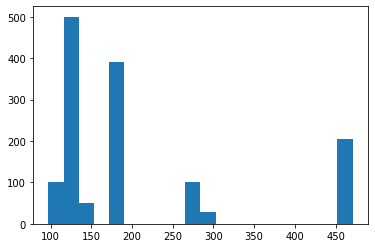

In [2]:
from matplotlib import pyplot as plt

plt.hist([len(i) for i in X_train], bins=20)

In [3]:
import pandas as pd

df = pd.DataFrame(y_test)
df[0].value_counts()

SwedishLeaf    625
Adiac          391
FISH           175
Gun_Point      150
ECG200         100
Trace          100
Beef            30
Coffee          28
Name: 0, dtype: int64

In [23]:
from numba import jit
import random

@jit(nopython=True)
def dtw(a, b, norm_order=2):
    if len(a) != len(b):
        raise Exception('lenght of a is not equal to b')
    r = len(a) // 10
    dp = np.zeros((len(a), len(b)))
    for j in range(0, r+1):
        dp[0, j] = abs(a[0] - b[j]) ** norm_order
    for i in range(len(a)):
        for j in range(i-r, min(i+r+1, len(b))):
            min_prev = dp[i-1, j]
            if j > 0:
                min_prev = min(min_prev, dp[i-1, j-1])
                min_prev = min(min_prev, dp[i, j-1])
            dp[i, j] = abs(a[i] - b[j]) ** norm_order + min_prev
    return dp[len(a) - 1, len(b) - 1]

@jit(nopython=True)
def g(i, j, dp):
        return dp[i][j]

@jit(nopython=True)
def d(i, j, a, b, norm_order):
    return abs(a[i] - b[j])**norm_order

@jit(nopython=True)
def dtw_extra_neighbor(a, b, norm_order=2):
    if len(a) != len(b):
        raise Exception('lenght of a is not equal to b')
    r = len(a) // 10
    dp = np.zeros((len(a), len(b)))
    for j in range(0, r+1):
        dp[0, j] = abs(a[0] - b[j]) ** norm_order
    for i in range(len(a)):
        for j in range(i-r, min(i+r+1, len(b))):
            neighbor = []
            if i >= 1 and j >= 1:
                neighbor.append(g(i-1, j-1, dp) + 2*d(i, j, a, b, norm_order))
            if i >= 1 and j >= 2:
                neighbor.append(g(i-1, j-2, dp) + 2*d(i, j-1, a, b, norm_order) + d(i, j, a, b, norm_order))
            if i >= 2 and j >= 1:
                neighbor.append(g(i-2, j-1, dp) + 2*d(i-1, j, a, b, norm_order) + d(i, j, a, b, norm_order))
            if i >= 1 and j >= 3:
                neighbor.append(g(i-1, j-3, dp) + 2*d(i, j-2, a, b, norm_order) + d(i, j-1, a, b, norm_order) + d(i, j, a, b, norm_order))
            if i >= 3 and j >= 1:
                neighbor.append(g(i-3, j-1, dp) + 2*d(i-2, j, a, b, norm_order) + d(i-1, j, a, b, norm_order) + d(i, j, a, b, norm_order))
            if len(neighbor) == 0:
                dp[i, j] = 0
            else:
                dp[i, j] = min(neighbor)
            
    return dp[len(a) - 1, len(b) - 1]

@jit(nopython=True)
def dtw_asymmetric(a, b, norm_order=2):
    if len(a) != len(b):
        raise Exception('lenght of a is not equal to b')
    r = len(a) // 10
    dp = np.zeros((len(a), len(b)))
    for j in range(0, r+1):
        dp[0, j] = abs(a[0] - b[j]) ** norm_order
    for i in range(len(a)):
        for j in range(i-r, min(i+r+1, len(b))):
            neighbor = [g(i-1, j, dp) + 2*d(i, j, a, b, norm_order)]
            if j > 0:
                neighbor.append(g(i-1, j-1, dp) + d(i, j, a, b, norm_order))
                neighbor.append(g(i-1, j, dp) + d(i, j, a, b, norm_order))
            dp[i, j] = min(neighbor)
    return dp[len(a) - 1, len(b) - 1]

@jit(nopython=True)
def dtw_asymmetric_2(a, b, norm_order=2):
    if len(a) != len(b):
        raise Exception('lenght of a is not equal to b')
    r = len(a) // 10
    dp = np.zeros((len(a), len(b)))
    for j in range(0, r+1):
        dp[0, j] = abs(a[0] - b[j]) ** norm_order
    for i in range(len(a)):
        for j in range(i-r, min(i+r+1, len(b))):
            neighbor = [g(i-1, j, dp) + d(i, j, a, b, norm_order)]
            if j > 0:
                neighbor.append(g(i-1, j-1, dp) + d(i, j, a, b, norm_order))
                neighbor.append(g(i-1, j, dp) + 2*d(i, j, a, b, norm_order))
            dp[i, j] = min(neighbor)
    return dp[len(a) - 1, len(b) - 1]

In [5]:
from scipy.interpolate import interp1d
from scipy import stats

def rescale_ts(ts, length=100):
    x = np.linspace(0, len(ts)-1, num=len(ts))
    y = np.array(ts)

    f = interp1d(x, y)
    new_x = np.linspace(0, len(ts)-1, num=length)
    interpolated_y = f(new_x)
    
    return stats.zscore(interpolated_y)

In [6]:
new_dim = 100
X_train_rescaled = [rescale_ts(X, new_dim) for X in X_train]
X_test_rescaled = [rescale_ts(X, new_dim) for X in X_test]

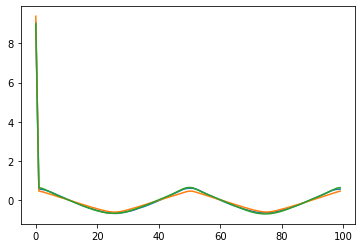

In [7]:
for i in range(3):
    plt.plot(X_train_rescaled[i])

In [8]:
from tqdm import tqdm

def knn(ts, dtw=dtw, k=5, X_train=X_train_rescaled, y_train=y_train):
    best_results = []
    for X, y in zip(X_train, y_train):
        best_results.append((dtw(ts, X, 2), y))
        best_results.sort()
        best_results = best_results[:k]
    return best_results

In [9]:
import random
from collections import defaultdict

class_size = defaultdict(int)
for label in y_train:
    class_size[label] += 1

def vote(knn_result):
    table = defaultdict(float)
    for dist, label in knn_result:
        table[label] += 1
    return max(table, key=table.get)


def random_test():
    test_index = random.randint(0, len(X_test))
    result = knn(X_test_rescaled[test_index])
    print('actual :', y_test[test_index])
    return result

knn_result = random_test()
print('predicted :', vote(knn_result))

actual : SwedishLeaf
predicted : SwedishLeaf


In [10]:
predicted = []

for x in tqdm(X_test_rescaled, total=len(X_test_rescaled)):
    result = vote(knn(x))
    predicted.append(result)

100%|██████████████████████████████████████████████████████████████████████████████| 1599/1599 [00:26<00:00, 61.00it/s]


In [1]:
with open('normal-predicted', 'w+') as f:
    f.write(' '.join(predicted))

NameError: name 'predicted' is not defined

In [12]:
predicted = np.array(predicted)
score = np.sum(np.array(y_test) == predicted)
score*100/len(y_test)

63.85240775484678

In [13]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, predicted)

<AxesSubplot:>

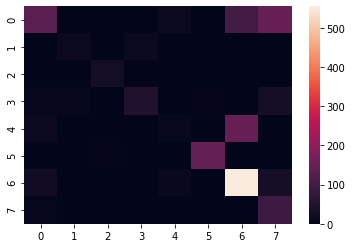

In [14]:
import seaborn as sn

sn.heatmap(conf)

In [15]:
predicted = []

for x in tqdm(X_test_rescaled, total=len(X_test_rescaled)):
    result = vote(knn(x, dtw=dtw_extra_neighbor))
    predicted.append(result)

100%|██████████████████████████████████████████████████████████████████████████████| 1599/1599 [28:22<00:00,  1.06s/it]


In [16]:
with open('more-neighbor-predicted', 'w+') as f:
    f.write(' '.join(predicted))

In [17]:
predicted = np.array(predicted)
score = np.sum(np.array(y_test) == predicted)
score*100/len(y_test)

71.85741088180113

<AxesSubplot:>

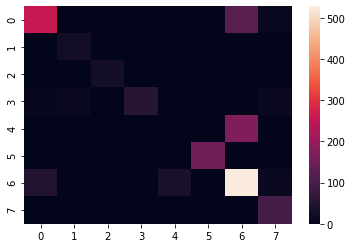

In [18]:
conf = confusion_matrix(y_test, predicted)
sn.heatmap(conf)

In [19]:
predicted = []

for x in tqdm(X_test_rescaled, total=len(X_test_rescaled)):
    result = vote(knn(x, dtw=dtw_asymmetric))
    predicted.append(result)

100%|██████████████████████████████████████████████████████████████████████████████| 1599/1599 [27:00<00:00,  1.01s/it]


In [20]:
with open('asymmetric-predicted', 'w+') as f:
    f.write(' '.join(predicted))

In [21]:
predicted = np.array(predicted)
score = np.sum(np.array(y_test) == predicted)
score*100/len(y_test)

86.30393996247655

<AxesSubplot:>

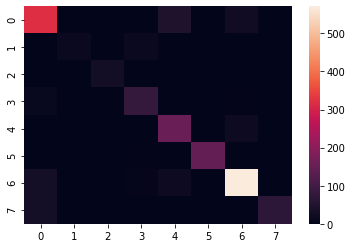

In [22]:
conf = confusion_matrix(y_test, predicted)
sn.heatmap(conf)

In [24]:
predicted = []

for x in tqdm(X_test_rescaled, total=len(X_test_rescaled)):
    result = vote(knn(x, dtw=dtw_asymmetric_2))
    predicted.append(result)

100%|██████████████████████████████████████████████████████████████████████████████| 1599/1599 [22:26<00:00,  1.19it/s]


In [25]:
with open('asymmetric-2-predicted', 'w+') as f:
    f.write(' '.join(predicted))

In [26]:
predicted = np.array(predicted)
score = np.sum(np.array(y_test) == predicted)
score*100/len(y_test)

86.30393996247655

<AxesSubplot:>

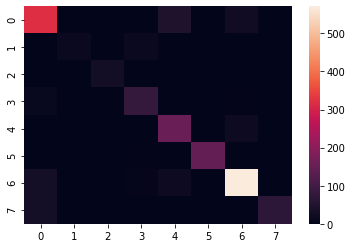

In [27]:
conf = confusion_matrix(y_test, predicted)
sn.heatmap(conf)